### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib.pyplot as plt
import tools
from numba.types import double, int32
from numba.experimental import jitclass
from scipy.interpolate import interp1d
from model import run_model
from params import par_class

plt.style.use('science') # pip install git+https://github.com/garrettj403/SciencePlots.git

### Settings

In [2]:
fast = True
save = True
do_figs = [1, 2, 3, 4, 5, 6, 7, 8, 9]
num_points = 16
dpi = 400

### Figure 1: Standard Buffer-Stock

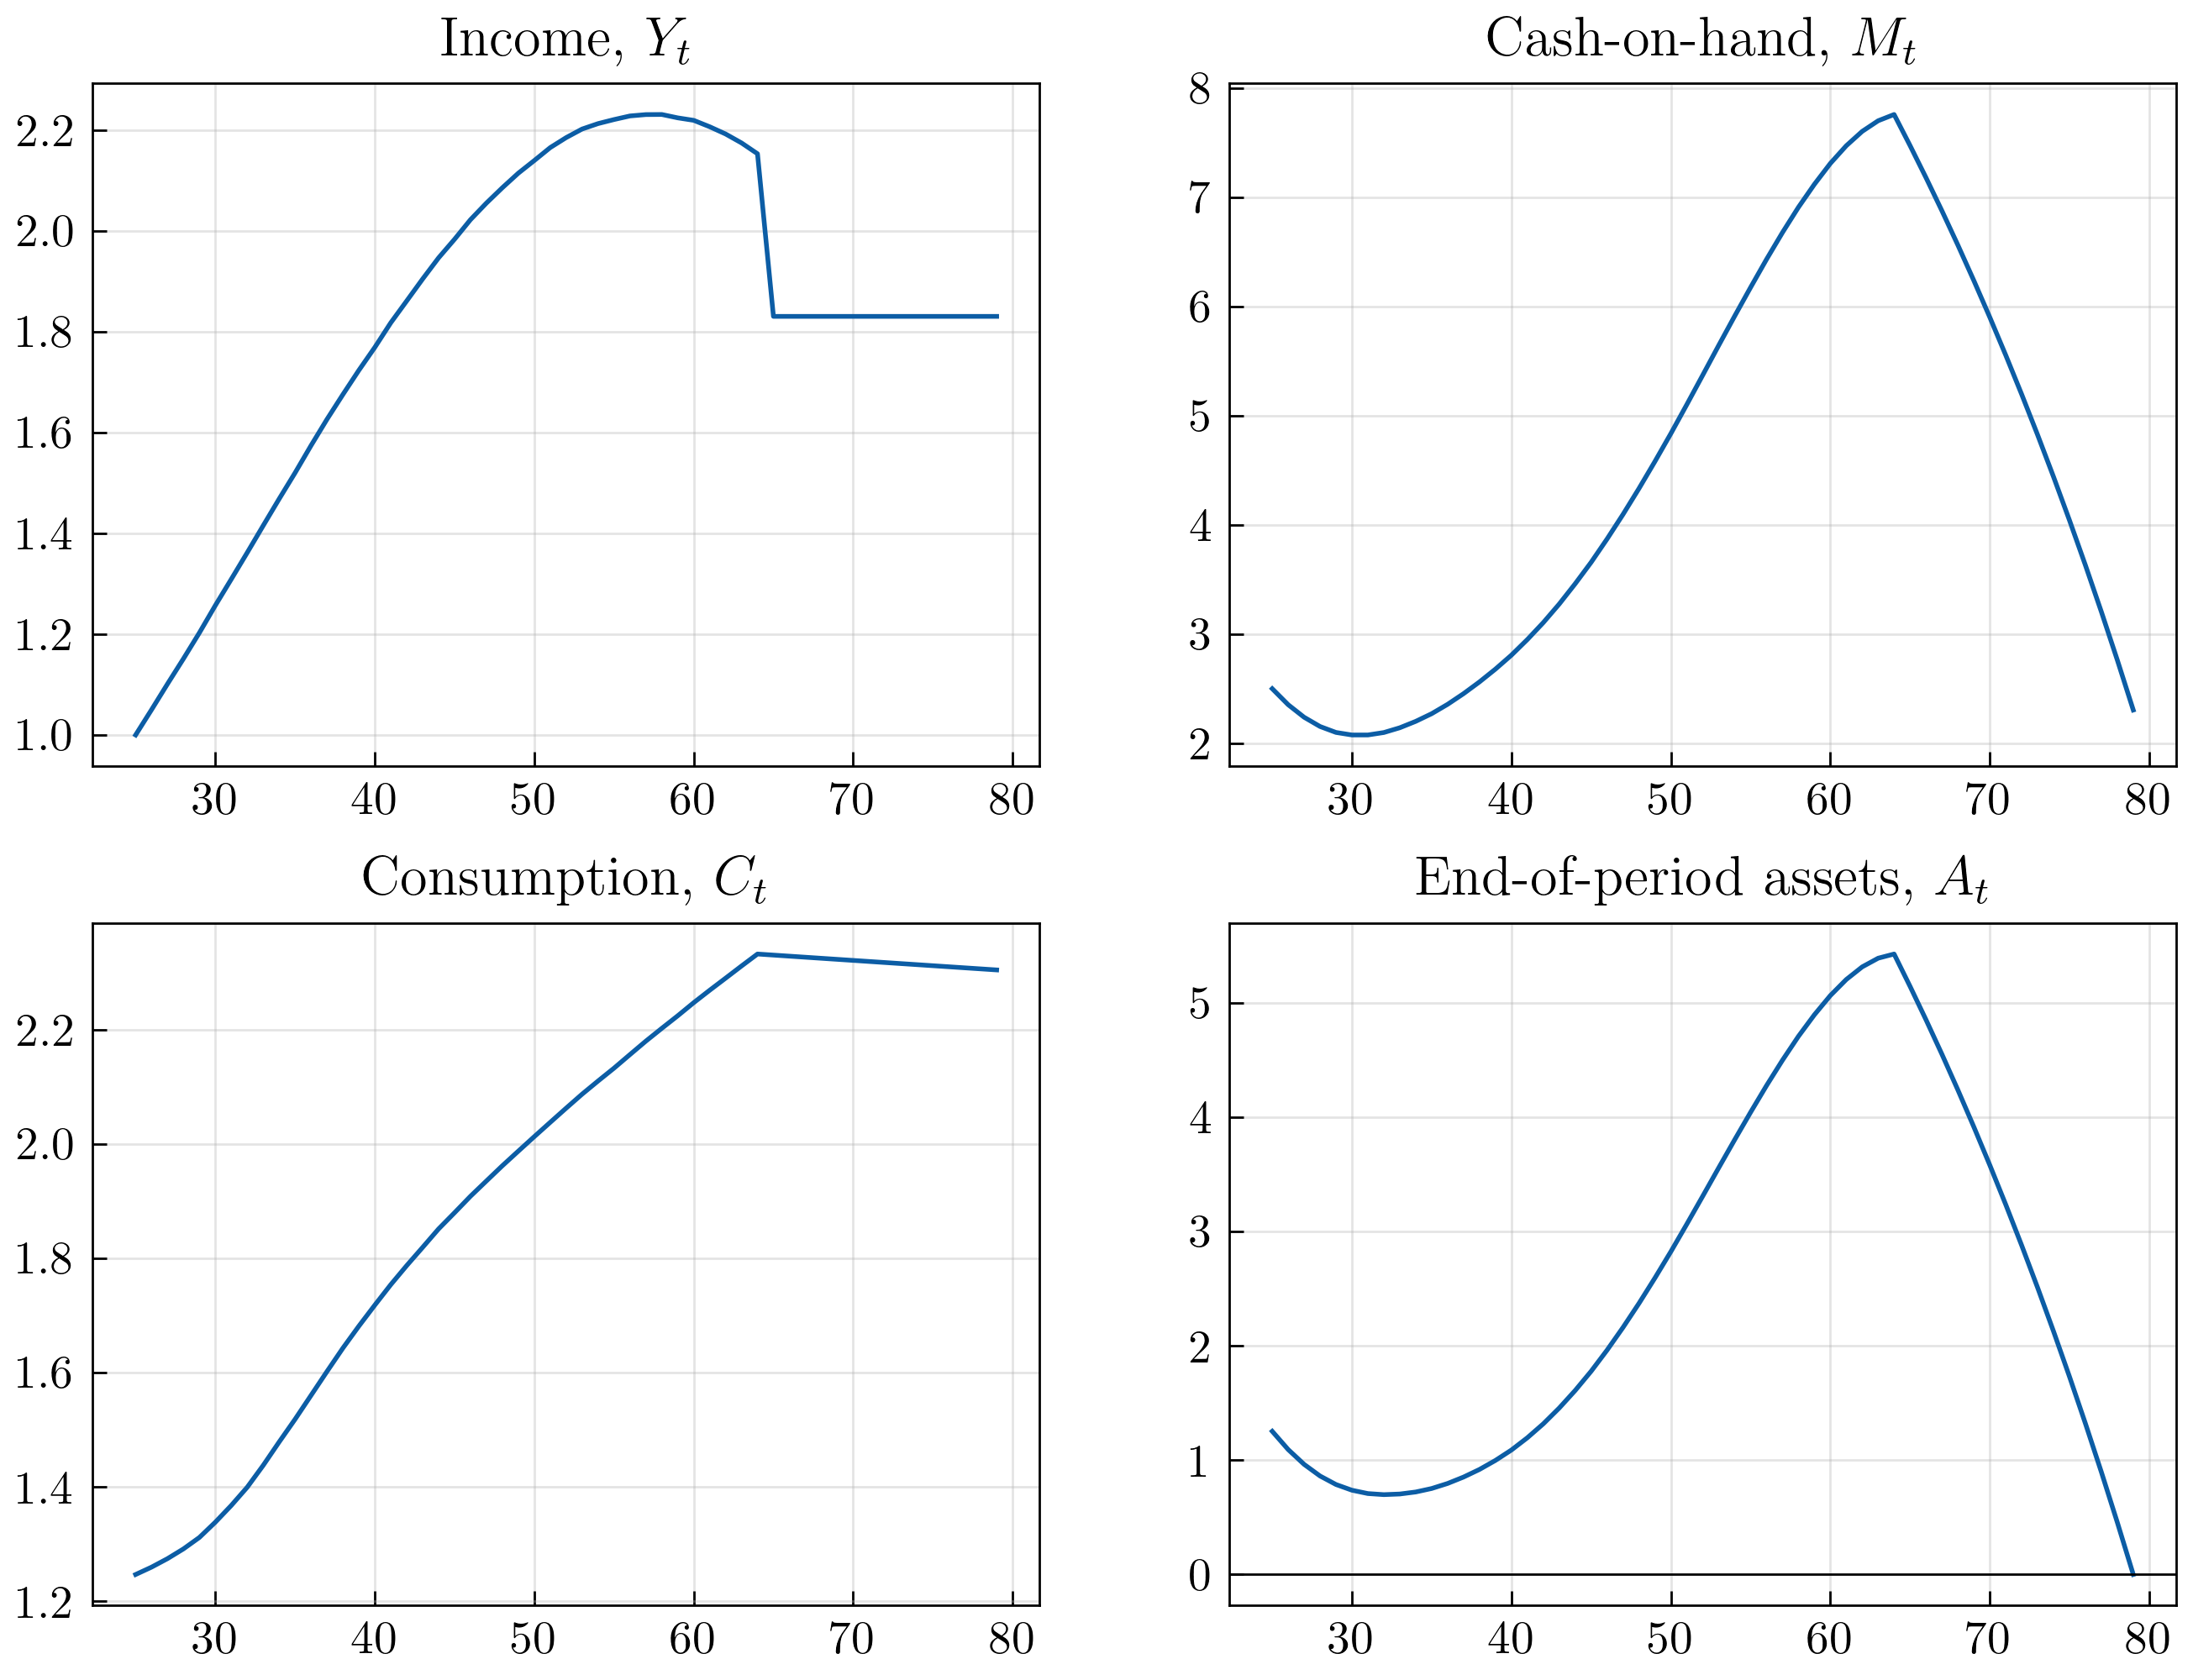

In [3]:
if 1 in do_figs:
    # Parameters
    par = par_class()
    par.alpha = 0.0
    par.sigma_d = 0.0
    par.Nh = 2
    par.Nd = 1
    if fast:
        par.Nm = 50

    # Model
    _, sim = run_model(par)

    # Plot
    fig,ax = plt.subplots(2,2,figsize=(8,6),dpi=dpi)
    ax[0,0].plot(range(25,80), sim.Y.mean(axis=0))
    ax[0,1].plot(range(25,80), sim.M.mean(axis=0))
    ax[1,0].plot(range(25,80), sim.C.mean(axis=0))
    ax[1,1].plot(range(25,80), sim.A.mean(axis=0))
    ax[0,0].set_title('Income, $Y_t$')
    ax[0,1].set_title('Cash-on-hand, $M_t$')
    ax[1,0].set_title('Consumption, $C_t$')
    ax[1,1].set_title('End-of-period assets, $A_t$')
    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].grid(alpha=1/3) # Make grid
            ax[i,j].minorticks_off() # Remove minor ticks
            ax[i,j].tick_params(top=False, right=False) # Remove major ticks on top and right 
            if (i,j) == (1,1): ax[i,j].axhline(0,color='black',alpha=1,lw=0.5) # Add zero line
    fig.subplots_adjust(hspace=0.23)
    if save: plt.savefig(r'figs\fig1.png')

### Figure 2: Exogenous holiday pay timing

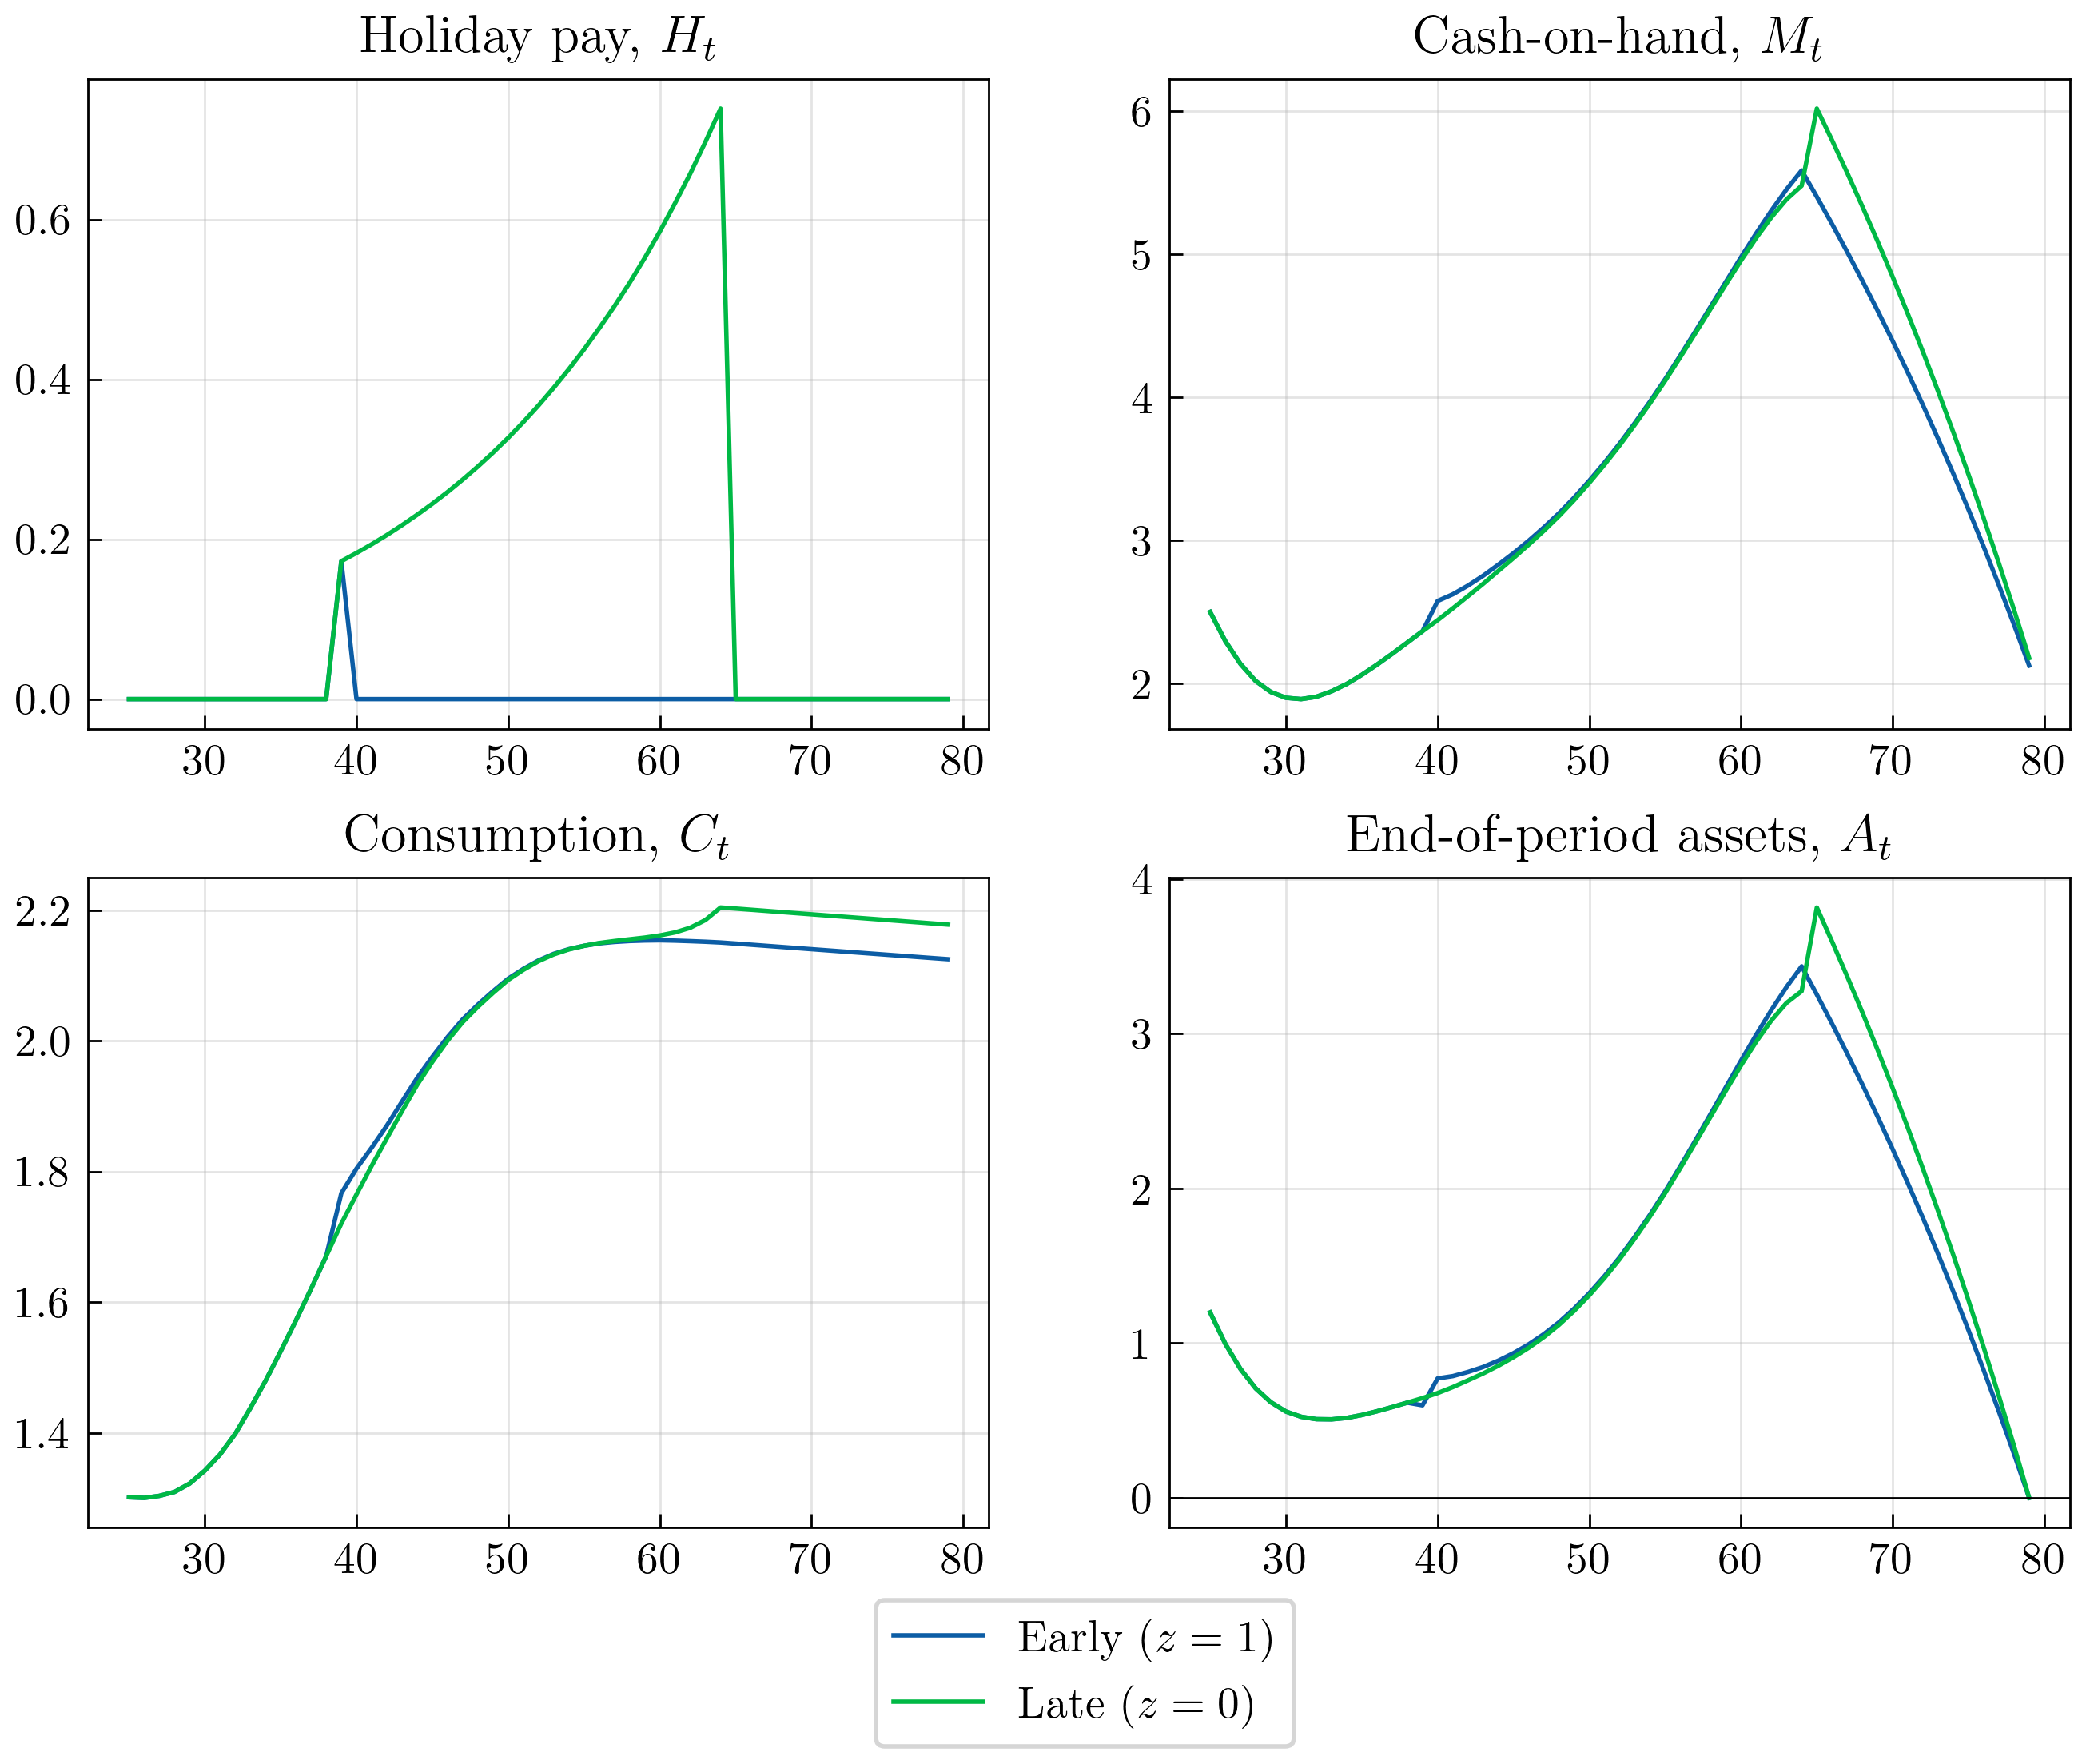

In [4]:
if 2 in do_figs:
    # Parameters
    par = par_class()
    par.sigma_psi = 0.0
    par.Npsi = 1
    par.z_mode = 1
    if fast:
        par.Nm = 50
        par.Nh = 10

    # Model
    _, sim_early = run_model(par)
    par.z_mode = 0
    _, sim_late = run_model(par)

    # Plot
    fig,ax = plt.subplots(2,2,figsize=(8,6),dpi=dpi)
    ax[0,0].plot(range(25,80), sim_early.H.mean(axis=0), label='Early ($z=1$)')
    ax[0,0].plot(range(25,80), sim_late.H.mean(axis=0), label='Late ($z=0$)')
    ax[0,1].plot(range(25,80), sim_early.M.mean(axis=0), label='Early ($z=1$)')
    ax[0,1].plot(range(25,80), sim_late.M.mean(axis=0), label='Late ($z=0$)')
    ax[1,0].plot(range(25,80), sim_early.C.mean(axis=0), label='Early ($z=1$)')
    ax[1,0].plot(range(25,80), sim_late.C.mean(axis=0), label='Late ($z=0$)')
    ax[1,1].plot(range(25,80), sim_early.A.mean(axis=0), label='Early ($z=1$)')
    ax[1,1].plot(range(25,80), sim_late.A.mean(axis=0), label='Late ($z=0$)')
    ax[0,0].set_title('Holiday pay, $H_t$')
    ax[0,1].set_title('Cash-on-hand, $M_t$')
    ax[1,0].set_title('Consumption, $C_t$')
    ax[1,1].set_title('End-of-period assets, $A_t$')
    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].grid(alpha=1/3) # Make grid
            ax[i,j].minorticks_off() # Remove minor ticks
            ax[i,j].tick_params(top=False, right=False) # Remove major ticks on top and right 
            if (i,j) == (1,1): ax[i,j].axhline(0,color='black',alpha=1,lw=0.5) # Add zero line
    fig.subplots_adjust(hspace=0.23)
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.42,0.01), frameon=True)
    if save: plt.savefig(r'figs\fig2.png')

### Figure 3: Endogenous holiday pay timining

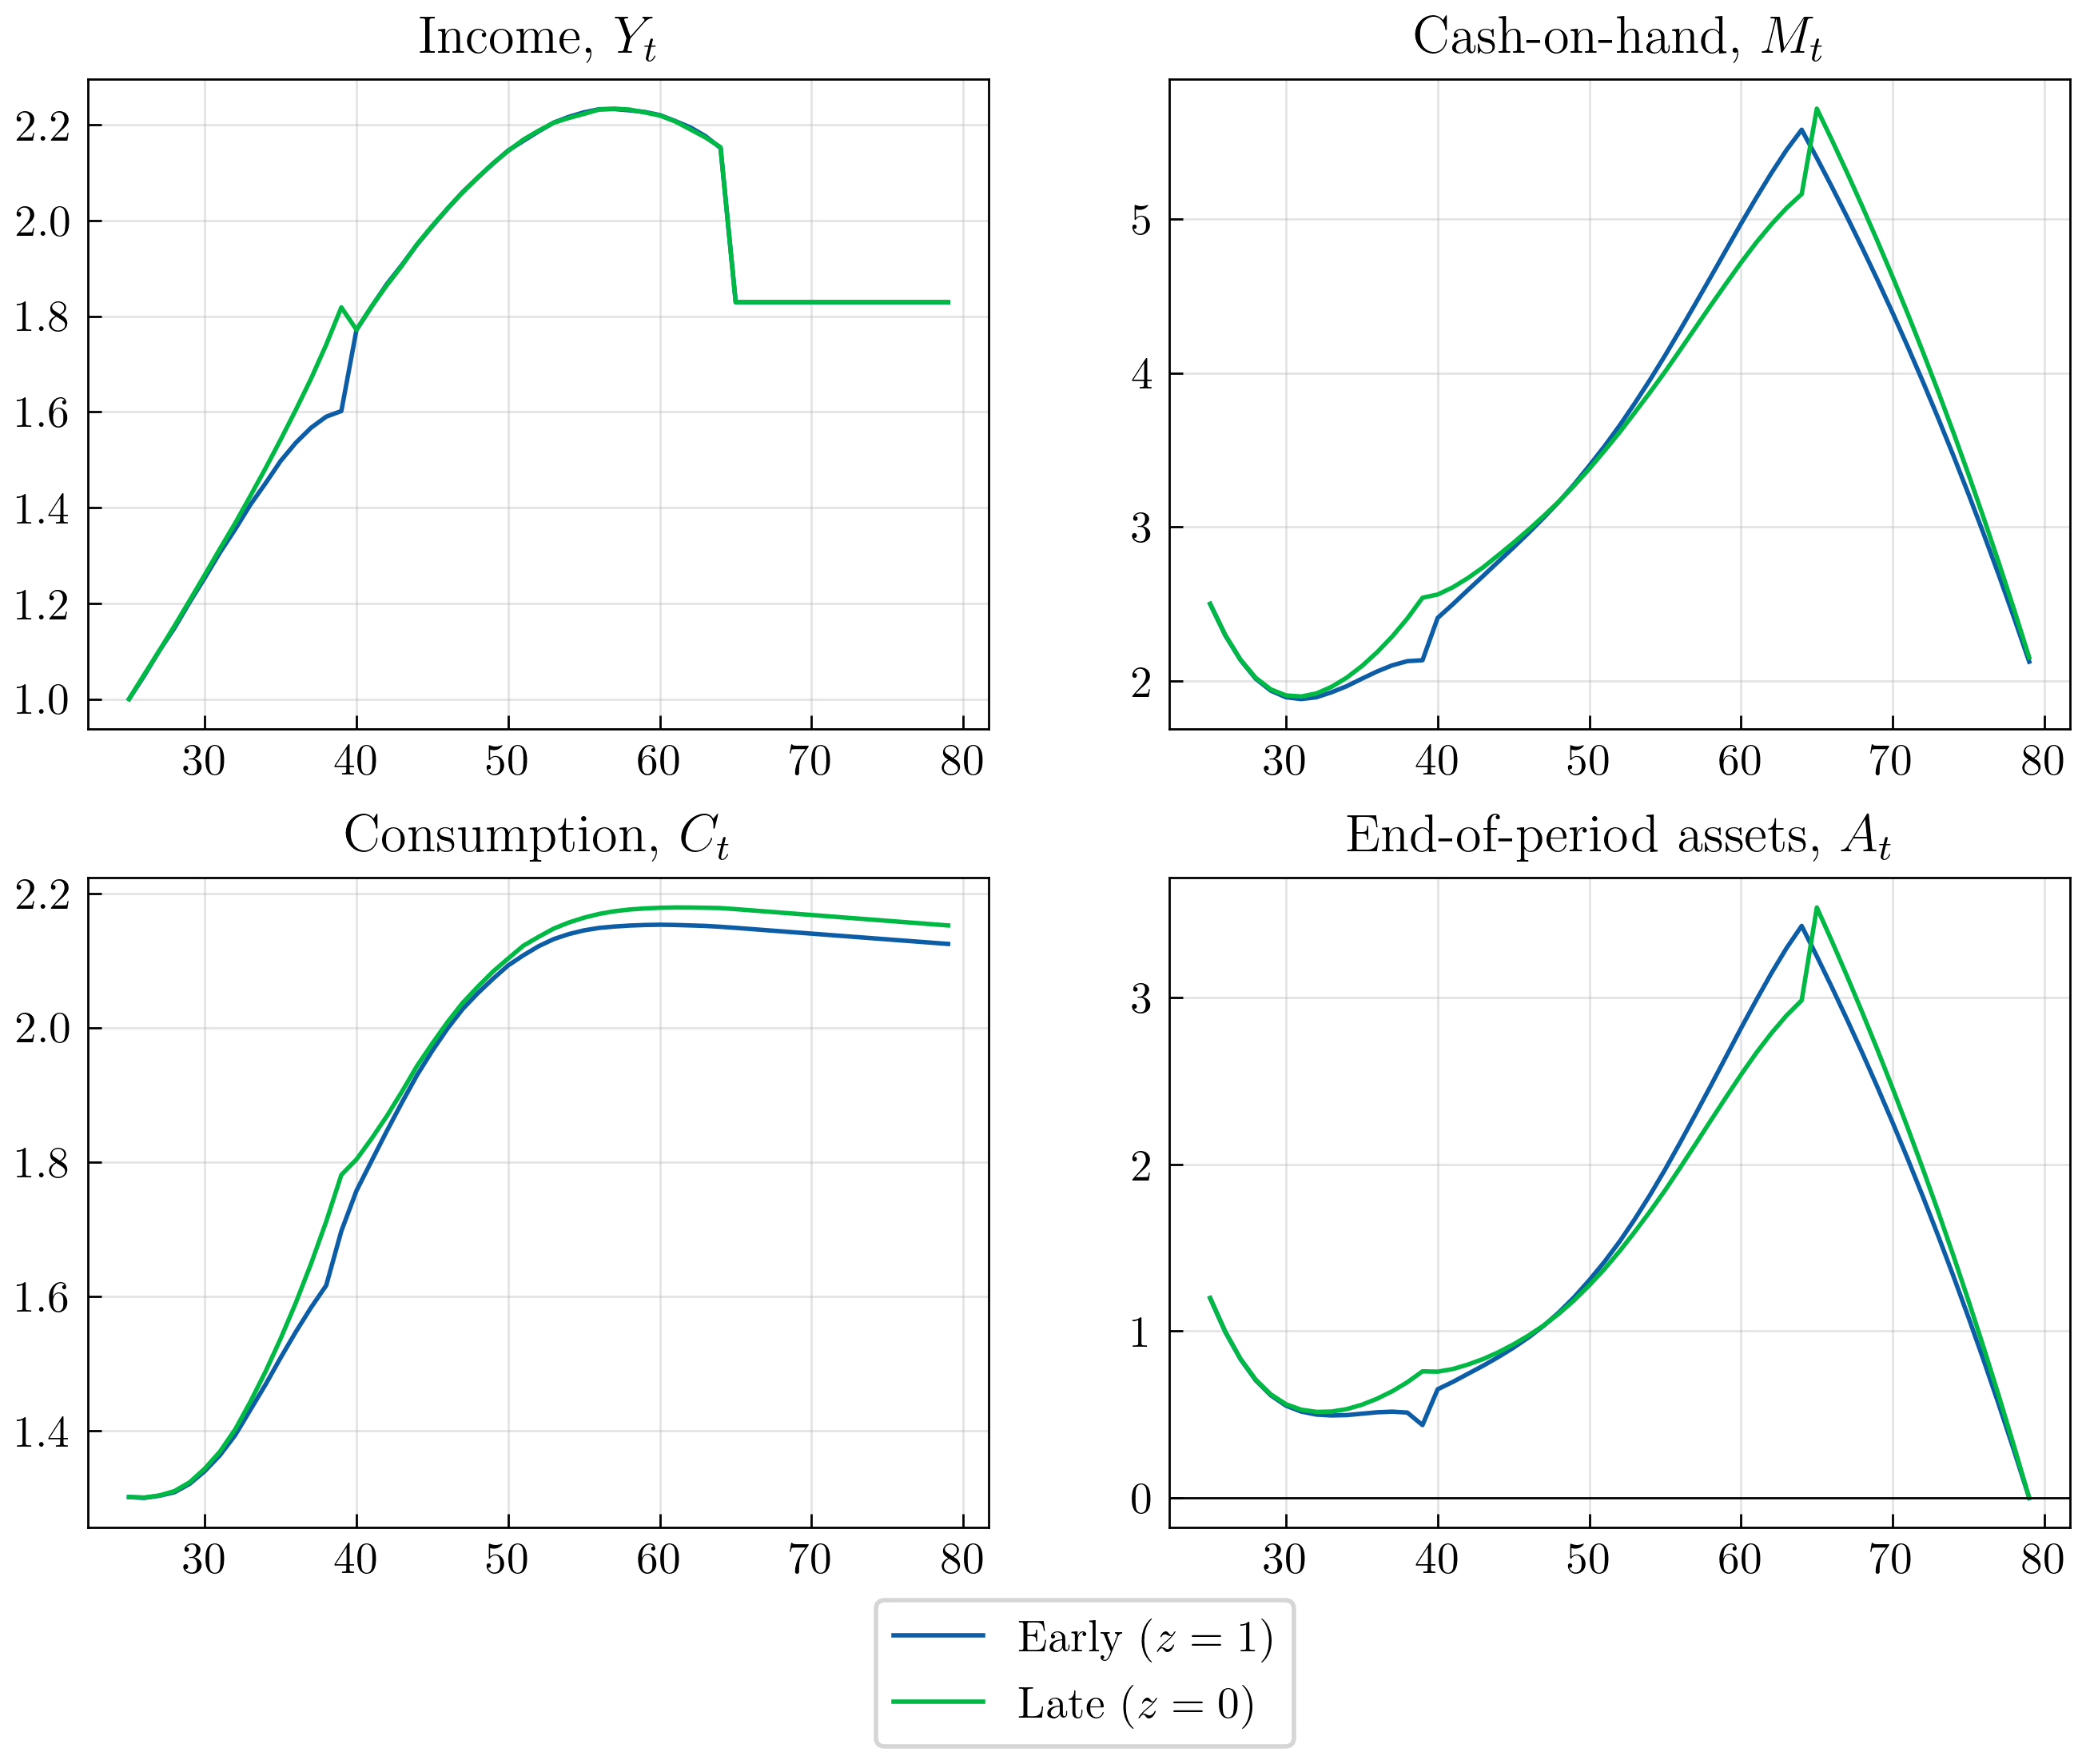

In [5]:
if 3 in do_figs:
    # Parameters
    par = par_class()
    par.sigma_psi = 0.0
    par.sigma_d = 0.0
    par.Nd = 1
    par.Npsi = 1
    if fast:
        par.Nm = 50
        par.Nh = 10

    # Model
    _, sim = run_model(par)

    # Seperate time series for early and late payments
    N_early = sum(sim.z)
    N_late  = par.simN - N_early
    sim_Y_early = np.nan + np.zeros((N_early,par.T))
    sim_Y_late  = np.nan + np.zeros((N_late,par.T))
    sim_M_early = np.nan + np.zeros((N_early,par.T))
    sim_M_late  = np.nan + np.zeros((N_late,par.T))
    sim_C_early = np.nan + np.zeros((N_early,par.T))
    sim_C_late  = np.nan + np.zeros((N_late,par.T))
    sim_A_early = np.nan + np.zeros((N_early,par.T))
    sim_A_late  = np.nan + np.zeros((N_late,par.T))
    i_early = 0
    i_late  = 0
    for i,z_i in enumerate(sim.z):
        if z_i == 1:
            sim_Y_early[i_early,:] = sim.Y[i,:]
            sim_M_early[i_early,:] = sim.M[i,:]
            sim_C_early[i_early,:] = sim.C[i,:]
            sim_A_early[i_early,:] = sim.A[i,:]
            i_early = i_early + 1
        else:
            sim_Y_late[i_late,:] = sim.Y[i,:]
            sim_M_late[i_late,:] = sim.M[i,:]
            sim_C_late[i_late,:] = sim.C[i,:]
            sim_A_late[i_late,:] = sim.A[i,:]
            i_late = i_late + 1

    # Plot
    fig,ax = plt.subplots(2,2,figsize=(8,6),dpi=dpi)
    ax[0,0].plot(range(25,80), sim_Y_early.mean(axis=0), label='Early ($z=1$)')
    ax[0,0].plot(range(25,80), sim_Y_late.mean(axis=0), label='Late ($z=0$)')
    ax[0,1].plot(range(25,80), sim_M_early.mean(axis=0), label='Early ($z=1$)')
    ax[0,1].plot(range(25,80), sim_M_late.mean(axis=0), label='Late ($z=0$)')
    ax[1,0].plot(range(25,80), sim_C_early.mean(axis=0), label='Early ($z=1$)')
    ax[1,0].plot(range(25,80), sim_C_late.mean(axis=0), label='Late ($z=0$)')
    ax[1,1].plot(range(25,80), sim_A_early.mean(axis=0), label='Early ($z=1$)')
    ax[1,1].plot(range(25,80), sim_A_late.mean(axis=0), label='Late ($z=0$)')
    ax[0,0].set_title('Income, $Y_t$')
    ax[0,1].set_title('Cash-on-hand, $M_t$')
    ax[1,0].set_title('Consumption, $C_t$')
    ax[1,1].set_title('End-of-period assets, $A_t$')
    for i in [0,1]:
        for j in [0,1]:
            ax[i,j].grid(alpha=1/3) # Make grid
            ax[i,j].minorticks_off() # Remove minor ticks
            ax[i,j].tick_params(top=False, right=False) # Remove major ticks on top and right 
            if (i,j) == (1,1): ax[i,j].axhline(0,color='black',alpha=1,lw=0.5) # Add zero line
    fig.subplots_adjust(hspace=0.23)
    handles, labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.42,0.01), frameon=True)
    if save: plt.savefig(r'figs\fig3.png')

### Figure 4: Payouts as a function of $\delta$

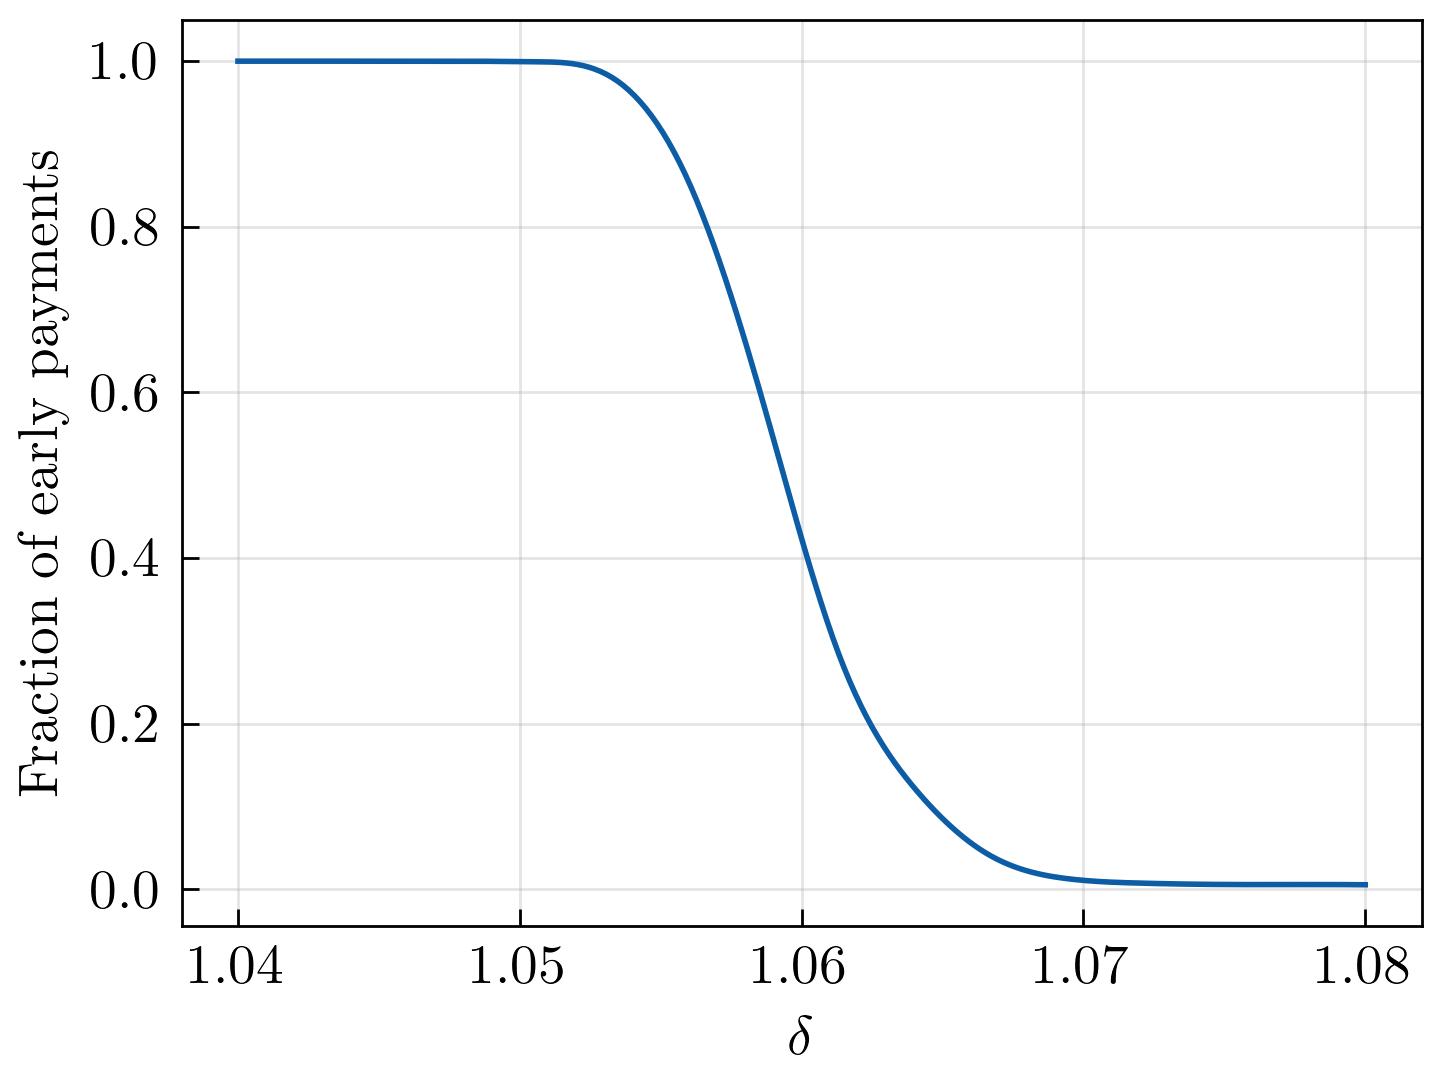

In [6]:
if 4 in do_figs:
    # Parameters
    ar = par_class()
    par.sigma_psi = 0.0
    par.sigma_d = 0.0
    par.Nd = 1
    par.Npsi = 1
    if fast:
        par.Nm = 50
        par.Nh = 10

    # Run models
    deltas = np.linspace(1.04, 1.08, num_points)
    zs = []
    for delta in deltas:
        par.delta = delta
        _, sim = run_model(par)
        zs.append(sim.z.mean())
        
    # Interpolate
    interpolator = interp1d(deltas, zs, kind='cubic')
    deltas_interp = np.linspace(1.04, 1.08, num=200, endpoint=True)
    zs_interp = interpolator(deltas_interp)

    # Graph
    plt.figure(figsize=(4,3),dpi=dpi)
    plt.plot(deltas_interp,zs_interp)
    plt.grid(alpha=1/3)
    plt.minorticks_off()
    ax = plt.gca()
    ax.tick_params(top=False, right=False)
    plt.xlabel('$\delta$')
    plt.ylabel('Fraction of early payments')
    if save: plt.savefig(r'figs\fig4.png')

### Figure 5: Payouts as a function of $\sigma_{\xi}$

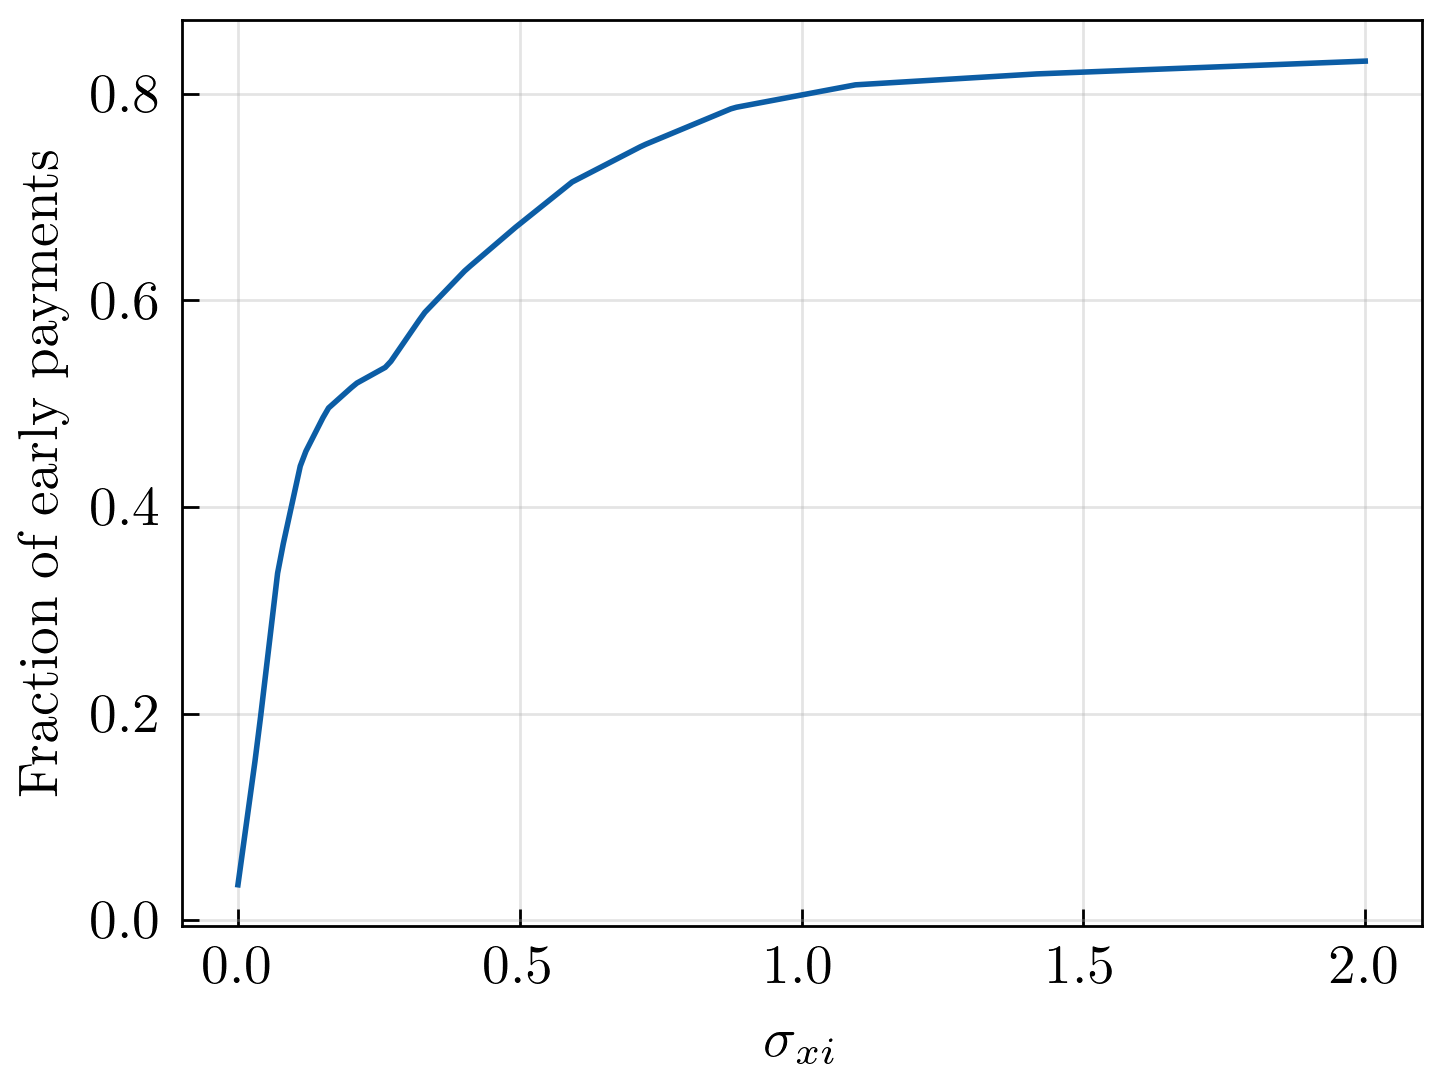

In [7]:
if 5 in do_figs:
    # Parameters
    par = par_class()
    par.sigma_psi = 0.0
    par.sigma_d = 0.0
    par.Nd = 1
    par.Npsi = 1
    par.Nxi = 12
    if fast:
        par.Nm = 50
        par.Nh = 10

    # Run models
    zs = []
    sigma_xis = tools.nonlinspace(0, 2, num_points, 1.5)
    for sigma_xi in sigma_xis:
        par.sigma_xi = sigma_xi
        _, sim = run_model(par)
        zs.append(sim.z.mean())

    # Interpolate
    interpolator = interp1d(sigma_xis, zs, kind='linear')
    sigma_xis_interp = np.linspace(0.0, 2.0, num=200, endpoint=True)
    zs_interp = interpolator(sigma_xis_interp)

    # Graph
    plt.figure(figsize=(4,3),dpi=dpi)
    plt.plot(sigma_xis_interp,zs_interp)
    plt.grid(alpha=1/3)
    plt.minorticks_off()
    ax = plt.gca()
    ax.tick_params(top=False, right=False)
    plt.xlabel('$\sigma_{xi}$')
    plt.ylabel('Fraction of early payments')
    if save: plt.savefig(r'figs\fig5.png')

### Figure 6: Payouts as a function of $\beta$

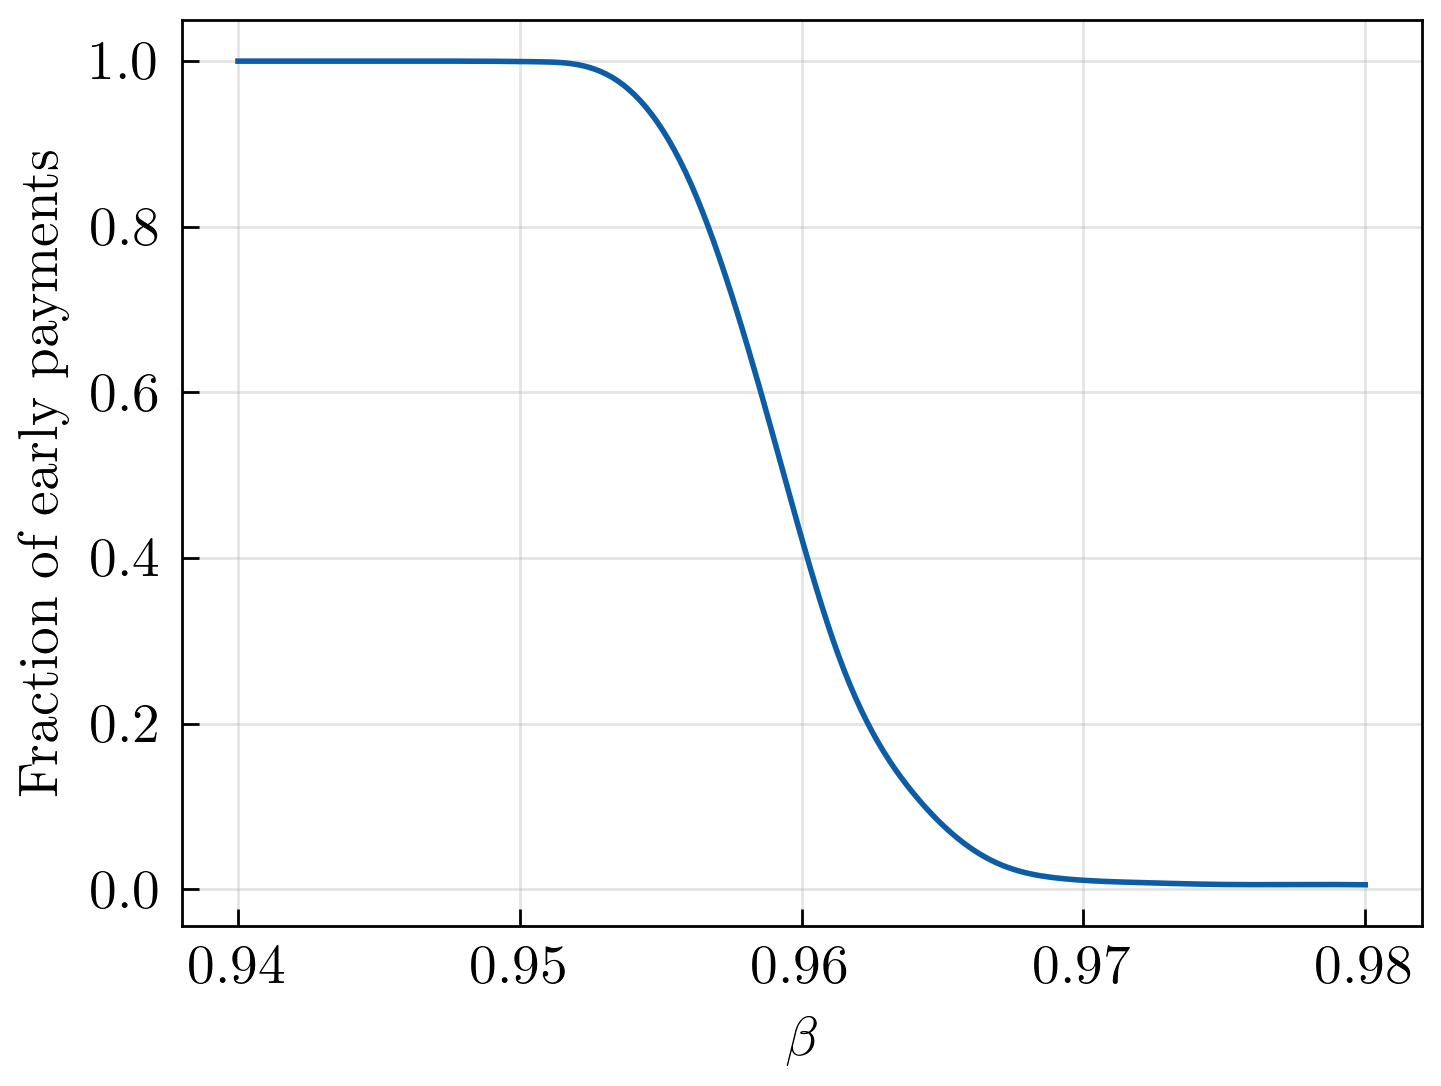

In [8]:
if 6 in do_figs:
    # Parameters
    par = par_class()
    par.sigma_psi = 0.0
    par.sigma_d = 0.0
    par.Nd = 1
    par.Npsi = 1
    if fast:
        par.Nm = 50
        par.Nh = 10

    # Run models
    zs = []
    betas = np.linspace(0.94, 0.98, num_points)
    for beta in betas:
        par.beta = beta
        _, sim = run_model(par)
        zs.append(sim.z.mean())

    # Interpolate
    interpolator = interp1d(betas, zs, kind='cubic')
    betas_interp = np.linspace(0.94, 0.98, num=200, endpoint=True)
    zs_interp = interpolator(betas_interp)

    # Graph
    plt.figure(figsize=(4,3),dpi=dpi)
    plt.plot(betas_interp,zs_interp)
    plt.grid(alpha=1/3)
    plt.minorticks_off()
    ax = plt.gca()
    ax.tick_params(top=False, right=False)
    plt.xlabel(r'$\beta$')
    plt.ylabel('Fraction of early payments')
    if save: plt.savefig(r'figs\fig6.png')

### Figure 7: Payouts as a function of $R$

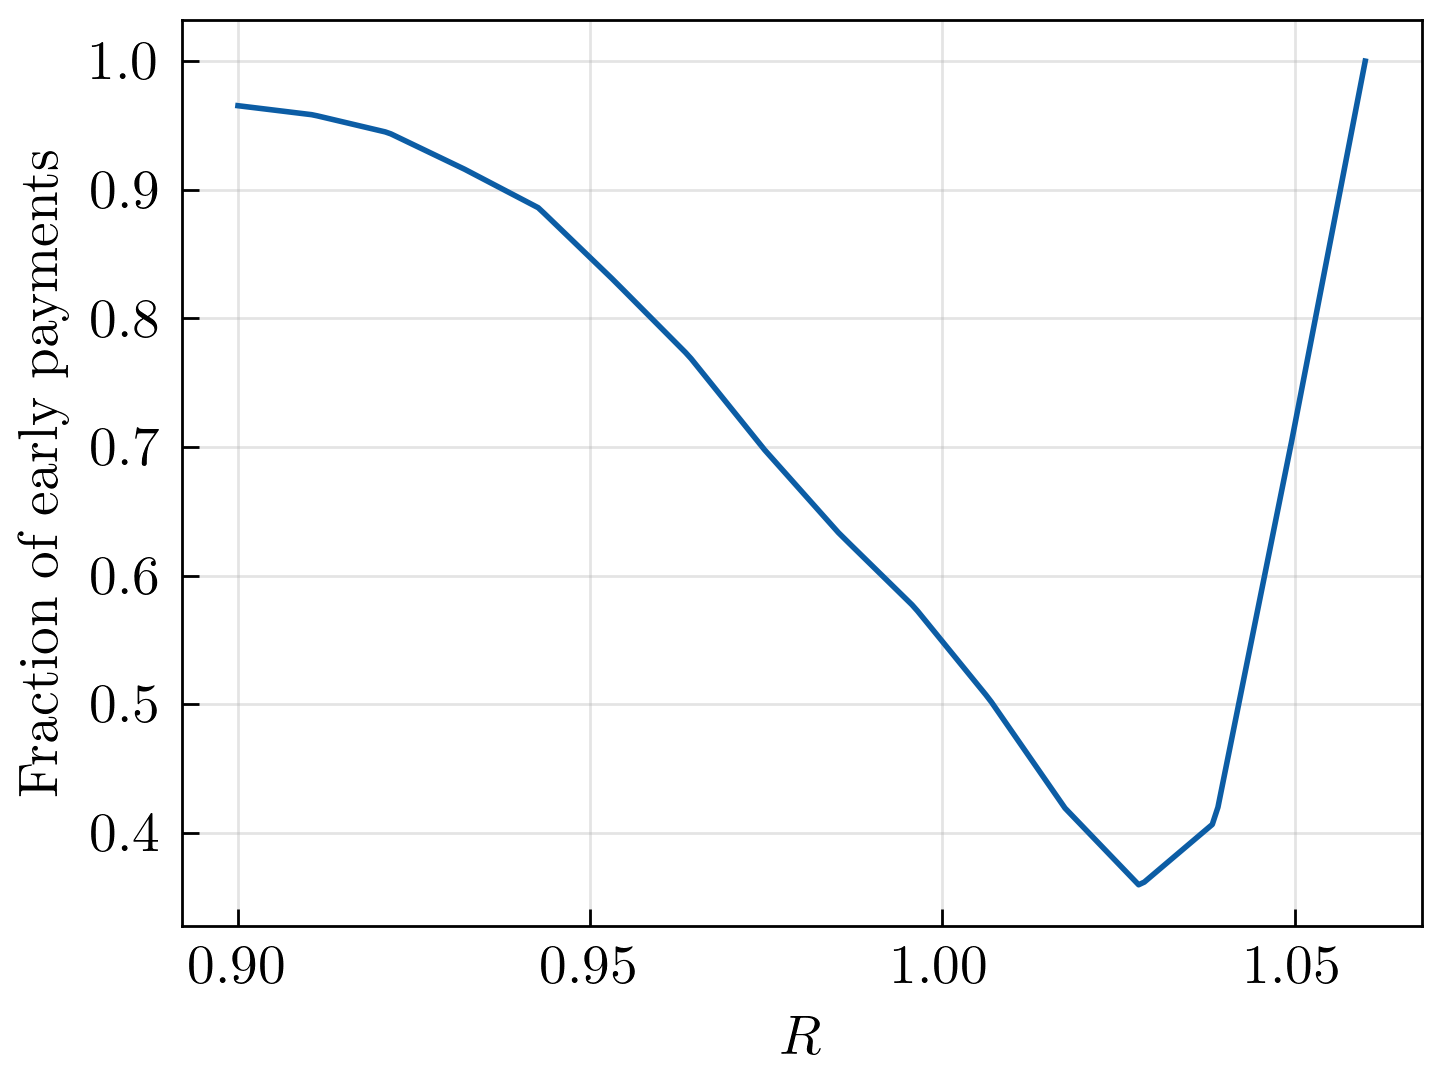

In [9]:
if 7 in do_figs:
    # Parameters
    par = par_class()
    par.sigma_psi = 0.0
    par.sigma_d = 0.0
    par.Nd = 1
    par.Npsi = 1
    if fast:
        par.Nm = 50
        par.Nh = 10

    # Run models
    zs = []
    Rs = np.linspace(0.90, 1.06, num_points)
    for R in Rs:
        par.R = R
        _, sim = run_model(par)
        zs.append(sim.z.mean())

    # Interpolate
    interpolator = interp1d(Rs, zs, kind='linear')
    Rs_interp = np.linspace(0.90, 1.06, num=200, endpoint=True)
    zs_interp = interpolator(Rs_interp)

    # Graph
    plt.figure(figsize=(4,3),dpi=dpi)
    plt.plot(Rs_interp,zs_interp)
    plt.grid(alpha=1/3)
    plt.minorticks_off()
    ax = plt.gca()
    ax.tick_params(top=False, right=False)
    plt.xlabel('$R$')
    plt.ylabel('Fraction of early payments')
    if save: plt.savefig(r'figs\fig7.png')

### Figure 8: (Inverse ratio) value function at $t=T_H-1$ as a function of early payment indicator

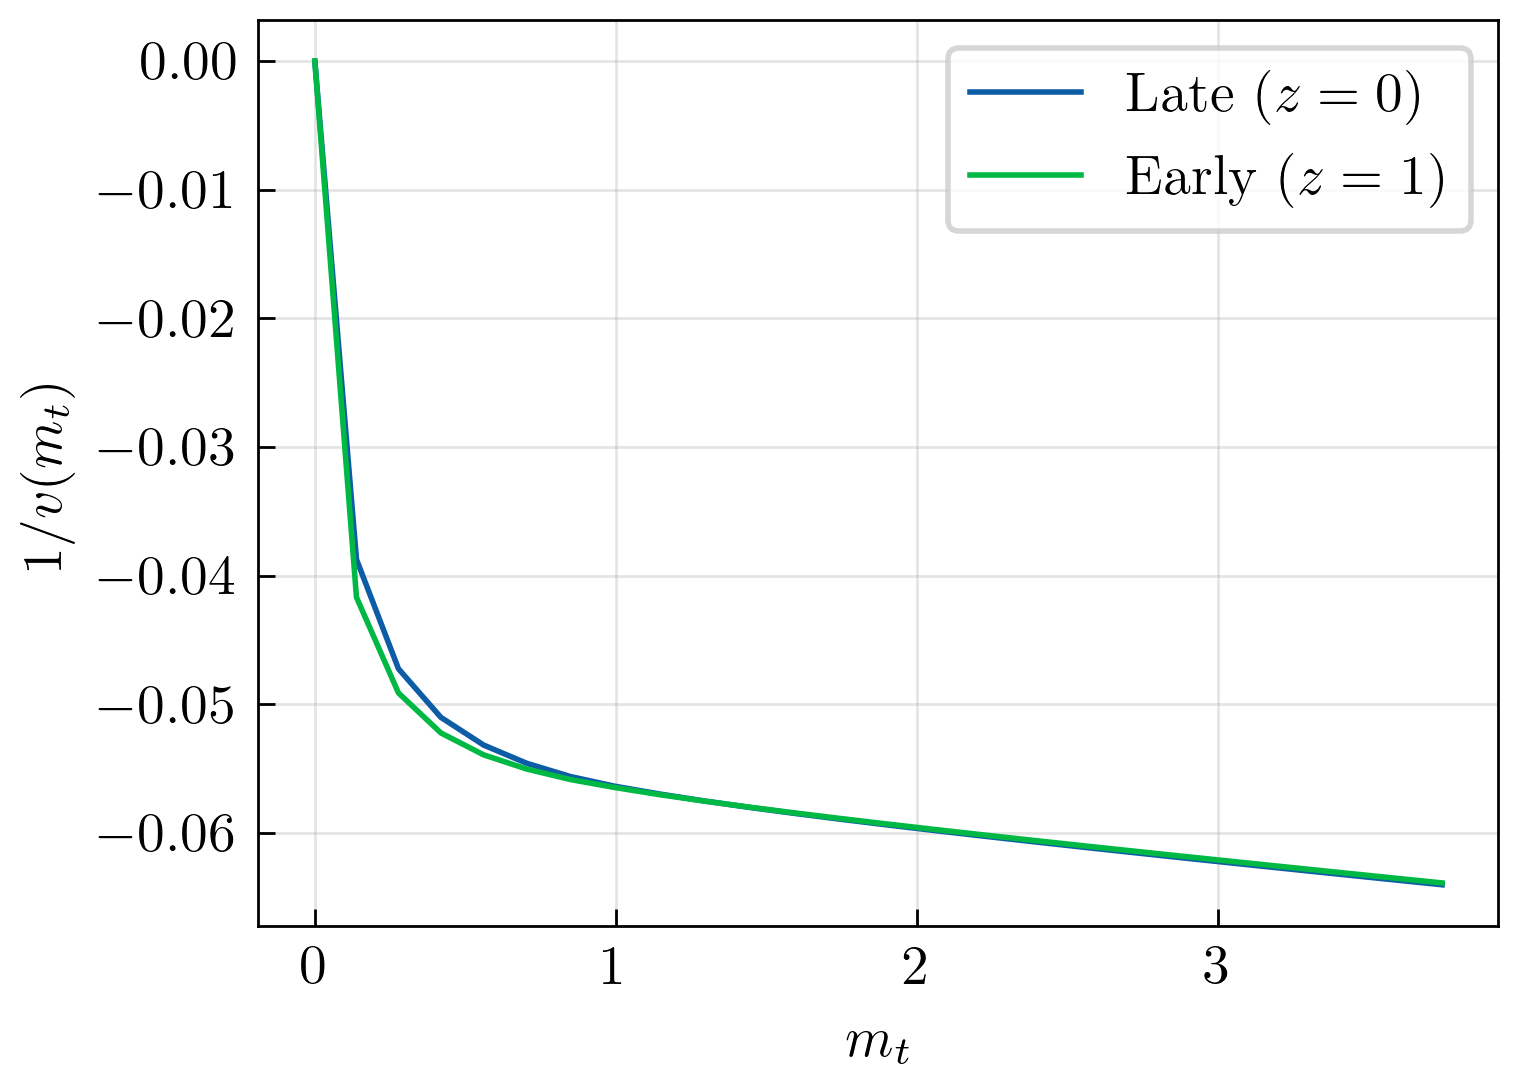

In [10]:
if 8 in do_figs:
    # Parameters
    par = par_class()
    par.sigma_psi = 0.0
    par.sigma_d = 0.0
    par.Nd = 1
    par.Npsi = 1
    par.Nh = 21 # Ensures that element number 2 in grid_h is 0.1
    par.h_phi = 1.0
    if fast:
        par.Nm = 50
        
    # Run model
    sol, sim = run_model(par)

    # Graph
    grid_m = tools.nonlinspace(1e-6,par.m_max,par.Nm,par.m_phi)
    plt.figure(figsize=(4,3),dpi=dpi)
    idx = (2-fast)*25
    plt.plot(grid_m[:idx], sol.inv_v[par.TH-1,:idx,0,2], label='Late ($z=0$)')
    plt.plot(grid_m[:idx], sol.inv_v[par.TH-1,:idx,1,2], label='Early ($z=1$)')
    plt.grid(alpha=1/3)
    plt.minorticks_off()
    ax = plt.gca()
    ax.tick_params(top=False, right=False)
    plt.xlabel('$m_t$')
    plt.ylabel('$1/v(m_t)$')
    plt.legend(frameon=True)
    if save: plt.savefig(r'figs\fig8.png')

### Figure 9: Consumption function at $t=T_R-5$ as a function of early payment indicator

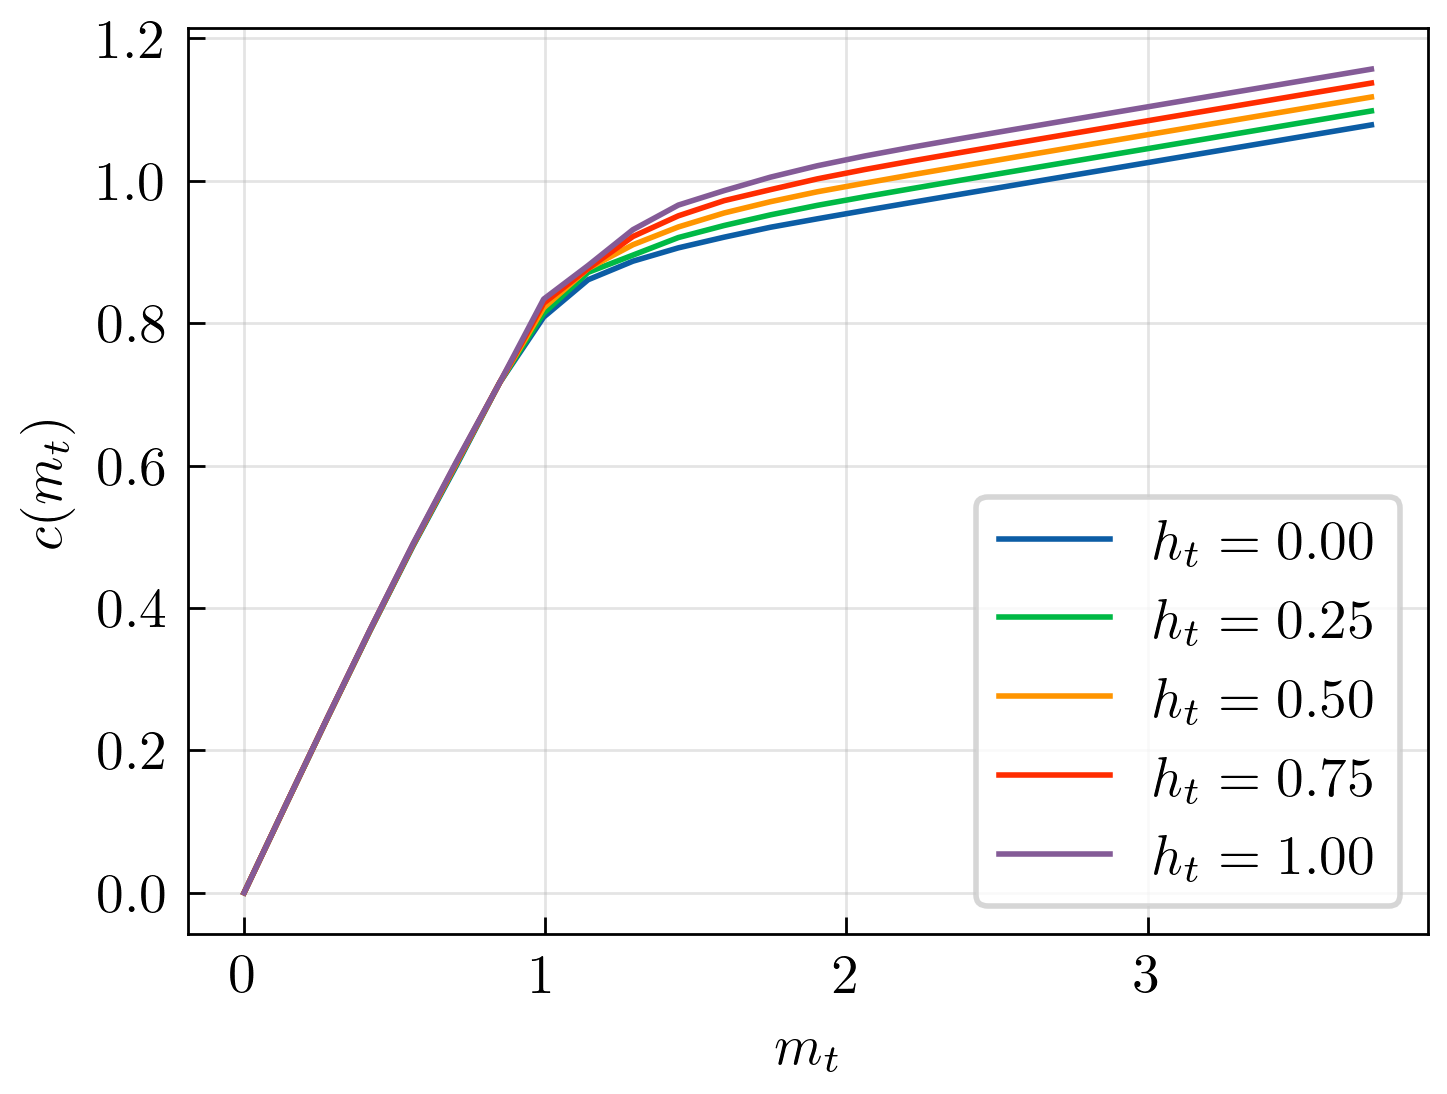

In [11]:
if 9 in do_figs:
    plt.figure(figsize=(4,3),dpi=dpi)
    plt.plot(grid_m[:idx], sol.c[par.TR-5,:idx,0,0], label='$h_t=0.00$')
    plt.plot(grid_m[:idx], sol.c[par.TR-5,:idx,0,5], label='$h_t=0.25$')
    plt.plot(grid_m[:idx], sol.c[par.TR-5,:idx,0,10], label='$h_t=0.50$')
    plt.plot(grid_m[:idx], sol.c[par.TR-5,:idx,0,15], label='$h_t=0.75$')
    plt.plot(grid_m[:idx], sol.c[par.TR-5,:idx,0,20], label='$h_t=1.00$')
    plt.grid(alpha=1/3)
    plt.minorticks_off()
    ax = plt.gca()
    ax.tick_params(top=False, right=False)
    plt.xlabel('$m_t$')
    plt.ylabel('$c(m_t)$')
    plt.legend(frameon=True)
    if save: plt.savefig(r'figs\fig9.png')